# Figure. eQTL Summary

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_eqtl_summary'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_processing/no_peer_no_std_norm01/h2.tsv'
h2 = pd.read_table(fn, index_col=0, header=None, squeeze=True)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
exp = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
sig = lead_vars[lead_vars.perm_sig]

fn = os.path.join(ciepy.root, 'output', 'gtex_analysis', 'plot_data.tsv')
plotd = pd.read_table(fn, index_col=0)
plotd = plotd.drop('Testis')
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)

In [5]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

qvalue_sig = qvalues[qvalues.perm_sig == 1]
qvalue_sig = qvalue_sig.sort_values('perm_qvalue')

In [6]:
log_exp = np.log10(exp + 1)
#log_exp = (log_exp.T - log_exp.mean(axis=1)).T
log_exp = log_exp[rna_meta[rna_meta.in_eqtl].index]
log_exp.columns = rna_meta[rna_meta.in_eqtl].wgs_id

In [7]:
# Markers of pluripotency from http://www.nature.com/nbt/journal/v33/n11/full/nbt.3387.html.
pgenes = ['CXCL5', 'IDO1', 'LCK', 'TRIM22', 'DNMT3B', 'HESX1', 'SOX2', 'POU5F1', 'NANOG']
genes = []
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in qvalues[qvalues.perm_sig].index:
        genes.append(i)

In [8]:
pdf = gene_info.ix[genes]
t_h2 = []
t_r2 = []
for g in pdf.index:
    fn = os.path.join(ciepy.root, 'private_output/run_eqtl_analysis/no_peer_no_std_norm01/gene_results', 
                      g, '{}.tsv'.format(g))
    res = ciepy.read_emmax_output(fn)
    res = res.sort_values('PVALUE')
    t_r2.append(res.R2.values[0])
    fn = os.path.join(ciepy.root, 'private_output/run_eqtl_analysis/no_peer_no_std_norm01/gene_results', 
                      g, '{}.reml'.format(g))
    t_h2.append(pd.read_table(fn, index_col=0, header=None, squeeze=True)['h2'])
pdf['r2'] = t_r2
pdf['h2'] = t_h2
pdf

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level,r2,h2
gene_id,,,,,,,,,,,
ENSG00000163735.6,CXCL5,protein_coding,chr4,74861358,74864496,-,KNOWN,HAVANA,2,0.18400,0.799549
ENSG00000131203.8,IDO1,protein_coding,chr8,39759793,39785963,+,KNOWN,HAVANA,2,0.10650,0.715645
ENSG00000182866.12,LCK,protein_coding,chr1,32716839,32751766,+,KNOWN,HAVANA,2,0.05772,0.666568
ENSG00000204531.11,POU5F1,protein_coding,chr6,31132118,31148508,-,KNOWN,HAVANA,1,0.19070,0.799549


In [51]:
def eqtl_violin(gene_id, exp, ax):
    res = ciepy.read_emmax_output(res_fns[gene_id])
    res = res.sort_values('PVALUE')
    t =  vcf_reader.fetch(res.CHROM.values[0], 
                          res.BEG.values[0], 
                          res.BEG.values[0] + 1)
    r = t.next()
    tdf = pd.DataFrame(exp.ix[gene_id])
    tdf.columns = ['Expression']
    tdf['Genotype'] = 0
    hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
    tdf.ix[hets, 'Genotype'] = 1
    alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
    tdf.ix[alts, 'Genotype'] = 2
    ax = sns.violinplot(x='Genotype', y='Expression', data=tdf, color='grey',
                        order=[0, 1, 2], scale='count', linewidth=0.5)
    ax.set_ylabel('$\\log_{10}$ TPM', fontsize=8)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(8)
    sns.regplot(x='Genotype', y='Expression', data=tdf, scatter=False, color='red', 
                ci=None, line_kws={'linewidth':0.8})
    ax.set_ylabel('$\\log_{10}$ TPM', fontsize=8)
    ya, yb = plt.ylim()
    ax.set_xlabel('')
    #ax.set_xticklabels(['Homo.\nref.', 'Het.', 'Homo.\nalt.'], fontsize=8)
    ax.set_xticklabels([r.REF + r.REF, r.REF + str(r.ALT[0]), str(r.ALT[0]) + str(r.ALT[0])])
    ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
    ax.set_xlabel('Genotype', fontsize=8)
    return ax

In [85]:
?ax.grid

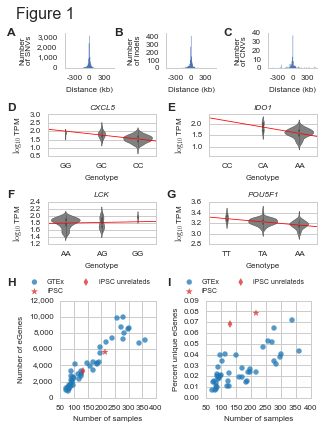

In [90]:
fig = plt.figure(figsize=(4.48, 6.1), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 1',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.95, 0.5, 1])

gs = gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
n,b,p = ax.hist(sig[sig.variant_type == 'snv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number\nof SNVs', fontsize=8)
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid('off')
ax.set_yticks(ax.get_yticks()[0::2])
    
ax = fig.add_subplot(gs[0, 1])
n,b,p = ax.hist(sig[(sig.variant_type == 'ins') | (sig.variant_type == 'del')].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number\nof indels', fontsize=8)
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid('off')
ax.set_yticks(ax.get_yticks()[0::2])
    
ax = fig.add_subplot(gs[0, 2])
n,b,p = ax.hist(sig[sig.variant_type == 'cnv'].tss_dist, 
                bins=np.arange(-500000, 510000, 10000),
                histtype='stepfilled', linewidth=0)
ax.set_ylabel('Number\nof CNVs', fontsize=8)
ticks = ax.set_xticks([-300000, 0, 300000])
ticks = ax.set_xticklabels([int(x) for x in ax.get_xticks() / 1000])
ax.set_xlim(-500000, 500000)
ax.set_xlabel('Distance (kb)', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid('off')
ax.set_yticks(ax.get_yticks()[0::2])
    
gs.tight_layout(fig, rect=[0, 0.75, 1, 0.95])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 0
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
gs.tight_layout(fig, rect=[0, 0.55, 0.5, 0.78])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 1
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
gs.tight_layout(fig, rect=[0.5, 0.55, 1, 0.78])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 2
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
gs.tight_layout(fig, rect=[0, 0.35, 0.5, 0.58])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 3
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_yticks(ax.get_yticks()[0::2])
gs.tight_layout(fig, rect=[0.5, 0.35, 1, 0.58])

# Number of eGenes vs. number of samples
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'num_sig_genes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=25, alpha=0.75)
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'num_sig_genes']],
           label='iPSC', color=cpb.analysis.tableau20[6], alpha=0.75, s=40, marker='*')
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'num_sig_genes']],
           label='iPSC unrelateds', color=cpb.analysis.tableau20[6], alpha=0.75, s=25, marker='d')
ax.legend(fontsize=7, loc='lower right', ncol=2, bbox_to_anchor=(1, 1))
ax.set_xlabel('Number of samples', fontsize=8)
ax.set_ylabel('Number of eGenes', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
#ax.legend(frameon=True, fancybox=True, fontsize=7, loc='lower right')
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0, 0, 0.52, 0.34])

# Percent distinct eGenes
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'percent_distinct_egenes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=25, alpha=0.75)
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'percent_distinct_egenes']],
           label='iPSC', color=cpb.analysis.tableau20[6], alpha=0.75, s=40, marker='*')
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'percent_distinct_egenes']],
           label='iPSC unrelateds', color=cpb.analysis.tableau20[6], alpha=0.75, s=25, marker='d')
ax.legend(fontsize=7, loc='lower right', ncol=2, bbox_to_anchor=(1, 1))
ax.set_xlabel('Number of samples', fontsize=8)
ax.set_ylabel('Percent unique eGenes', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
# ax.legend(frameon=True, fancybox=True, fontsize=7, loc='upper right')
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
gs.tight_layout(fig, rect=[0.48, 0, 1, 0.34])

t = fig.text(0.005, 0.91, 'A', weight='bold', 
             size=12)
t = fig.text(0.335, 0.91, 'B', weight='bold', 
             size=12)
t = fig.text(0.675, 0.91, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.74, 'D', weight='bold', 
             size=12)
t = fig.text(0.5, 0.74, 'E', weight='bold', 
             size=12)
t = fig.text(0.005, 0.54, 'F', weight='bold', 
             size=12)
t = fig.text(0.5, 0.54, 'G', weight='bold', 
             size=12)
t = fig.text(0.005, 0.34, 'H', weight='bold', 
             size=12)
t = fig.text(0.5, 0.34, 'I', weight='bold', 
             size=12)

fig.savefig(os.path.join(outdir, 'eqtl_summary.pdf'))